In [173]:
subj = "Subj1"
exp = "exp1"
scale = True

### Imports

In [183]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [175]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 3)


### SDA

In [176]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 3 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [184]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in  tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   92  154  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:06<00:00, 292.06it/s]


In [178]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [179]:
def analyze(result: pandas.DataFrame, key: str, folder: str, n_stages: int = 10):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    display(pandas.DataFrame([ best_result ]))
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
4,0,35,15,3,Mode,"[0, 52, 670, 1046]",242.79,1.73,0.02,110.88,2.85,0.18,103.10,2.35,0.47,0.22,0.46
22,0,45,15,4,Mode,"[0, 52, 670, 800, 1046]",223.24,1.74,-0.02,92.33,3.51,0.18,95.03,1.78,0.56,0.27,0.49
22,0,45,15,5,Mode,"[0, 52, 252, 670, 800, 1046]",177.40,1.40,-0.01,122.25,16.68,0.16,96.56,1.85,0.67,0.44,0.58
84,40,40,15,6,Median,"[0, 52, 252, 566, 670, 855, 1046]",168.30,1.42,-0.03,111.24,4.40,0.16,92.39,1.89,0.75,0.58,0.67
88,40,40,20,7,Mode,"[0, 52, 252, 490, 566, 670, 862, 1046]",143.38,1.37,-0.04,95.84,4.87,0.16,81.37,1.98,0.79,0.66,0.72
123,60,40,20,8,Median,"[0, 105, 252, 490, 566, 670, 855, 975, 1046]",118.05,1.28,-0.05,87.22,6.39,0.15,64.63,2.13,0.86,0.77,0.80
123,60,40,20,9,Median,"[0, 105, 252, 345, 490, 566, 670, 855, 975, 1046]",89.95,1.15,-0.06,77.21,6.46,0.13,48.78,2.58,0.84,0.71,0.74
15,0,40,20,10,Median,"[0, 52, 252, 388, 490, 572, 670, 749, 857, 955...",74.35,1.08,-0.07,67.02,6.61,0.12,42.82,3.07,0.79,0.60,0.64
132,60,45,20,11,Median,"[0, 105, 137, 252, 390, 490, 566, 670, 789, 85...",54.93,0.98,-0.09,63.47,7.91,0.10,29.10,3.09,0.87,0.75,0.78
15,0,40,20,12,Median,"[0, 52, 105, 252, 388, 490, 566, 609, 670, 749...",48.53,1.00,-0.11,59.58,6.08,0.10,27.83,2.92,0.80,0.61,0.66


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,20,10,Median,"[0, 52, 252, 388, 490, 572, 670, 749, 857, 955...",74.35,1.08,-0.07,67.02,6.61,0.12,42.82,3.07,0.79,0.6,0.64


array([   0,   52,  252,  388,  490,  572,  670,  749,  857,  955, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,2.53e-01,106.68,0.98,82.30,1.41
1,2.44e-01,168.37,1.21,143.91,1.33
2,2.24e-03,3.33,7.24,2.85,0.22
3,6.32e-02,22.57,2.47,17.66,0.62
4,2.45e-02,7.66,4.20,6.06,0.37
5,5.68e-02,13.21,3.17,10.80,0.50
6,4.06e-02,13.58,3.21,10.47,0.48
7,1.01e-01,21.35,2.68,20.94,0.64
8,1.12e-02,2.51,7.47,2.69,0.24


,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(9.9, 55.5)","(56.3, 236.3)","(237.1, 359.5)","(360.3, 453.1)","(454.7, 522.7)","(523.5, 610.7)","(611.5, 678.7)","(679.5, 771.5)","(772.3, 859.5)","(860.3, 938.7)"
"Time length, sec",45.6,180.0,122.4,92.8,68.0,87.2,67.2,92.0,87.2,78.4
Number of epochs,52,200,136,102,82,98,79,108,98,91


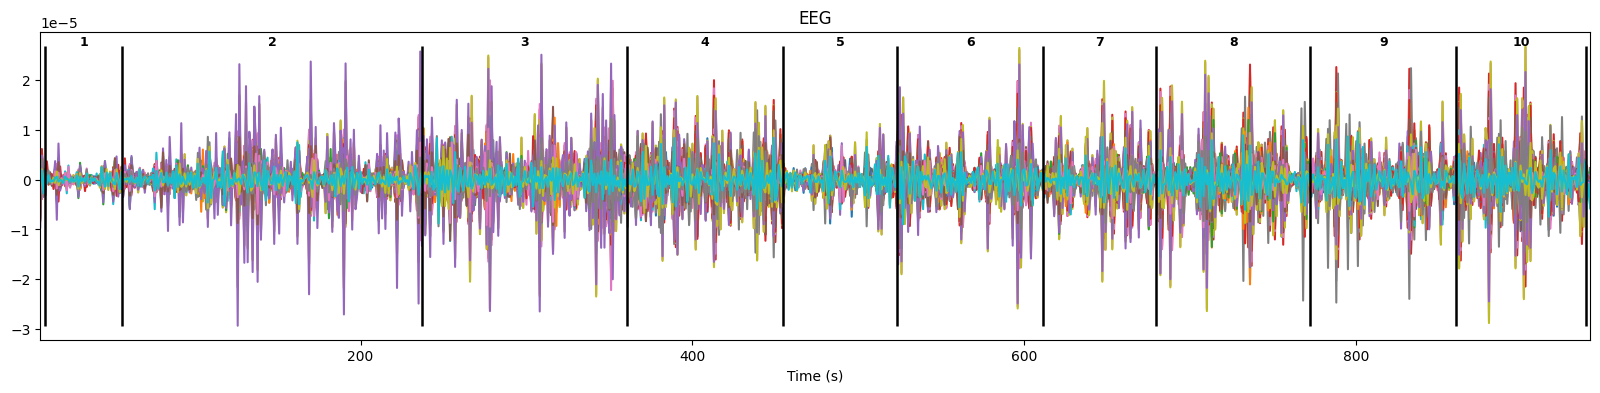

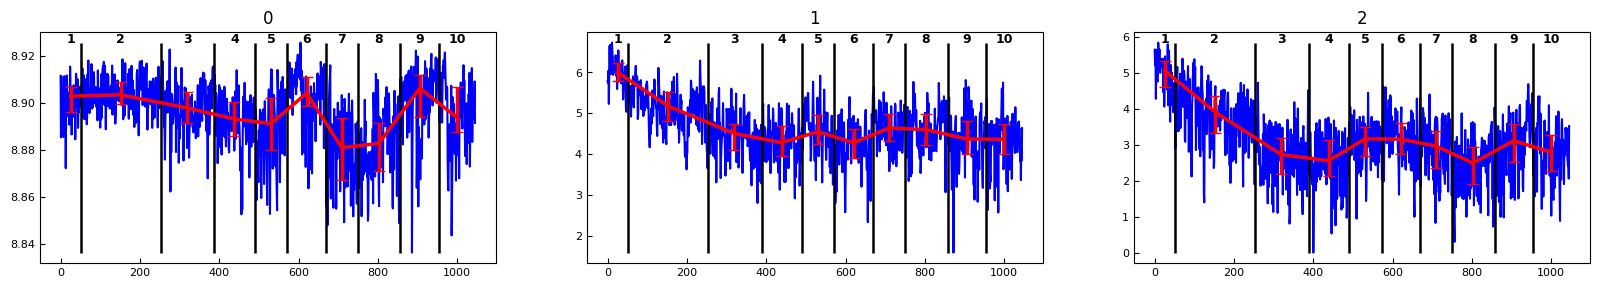

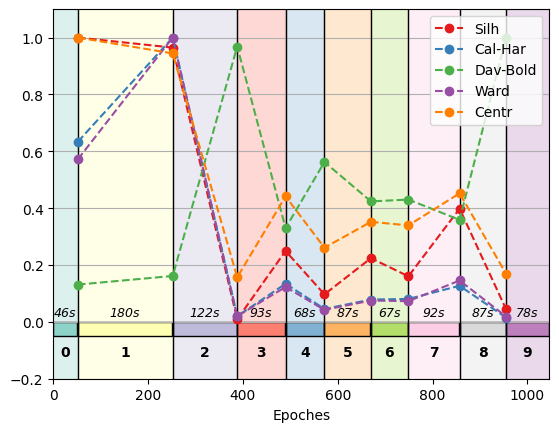

In [180]:
analyze(result, 'Avg-Silh', "internal")

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
109,60,35,10,3,Mode,"[0, 252, 670, 1046]",307.76,1.18,5.81e-02,171.33,4.67,0.14,156.13,3.82,0.59,0.35,0.54
101,40,50,10,4,Mean,"[0, 152, 561, 814, 1046]",170.59,0.99,2.54e-03,94.23,6.32,0.10,81.60,4.46,0.71,0.48,0.63
114,60,35,20,5,Median,"[0, 252, 557, 670, 857, 1046]",230.98,1.41,1.32e-02,117.31,4.98,0.16,116.15,2.06,0.76,0.58,0.67
119,60,40,10,6,Mean,"[0, 125, 266, 492, 674, 847, 1046]",112.02,1.11,-4.13e-02,98.70,5.78,0.12,61.56,2.60,0.81,0.71,0.76
108,60,35,10,7,Median,"[0, 136, 252, 490, 670, 789, 857, 1046]",79.60,1.01,-6.17e-02,87.27,5.87,0.10,44.26,2.97,0.83,0.72,0.77
114,60,35,20,8,Median,"[0, 136, 252, 490, 566, 670, 855, 976, 1046]",107.01,1.24,-5.65e-02,83.70,6.30,0.14,56.21,2.18,0.86,0.77,0.81
114,60,35,20,9,Median,"[0, 136, 252, 490, 566, 670, 789, 857, 976, 1046]",81.91,1.15,-6.43e-02,74.56,6.44,0.12,44.39,2.51,0.89,0.82,0.85
115,60,35,20,10,Mode,"[0, 136, 252, 316, 490, 566, 670, 800, 855, 97...",58.98,1.02,-7.39e-02,66.16,6.67,0.10,31.33,3.04,0.86,0.78,0.81
124,60,40,20,11,Mode,"[0, 105, 136, 252, 316, 490, 566, 670, 800, 86...",47.99,0.95,-8.18e-02,61.86,6.99,0.10,24.79,3.24,0.86,0.79,0.82
124,60,40,20,12,Mode,"[0, 105, 136, 252, 316, 490, 566, 670, 727, 80...",36.99,0.91,-8.87e-02,56.88,6.99,0.09,19.41,3.32,0.85,0.78,0.81


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,35,20,10,Mode,"[0, 136, 252, 316, 490, 566, 670, 800, 855, 97...",58.98,1.02,-0.07,66.16,6.67,0.1,31.33,3.04,0.86,0.78,0.81


array([   0,  136,  252,  316,  490,  566,  670,  800,  855,  977, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,1.66e-01,72.93,1.61,62.14,1.00
1,1.59e-01,51.39,1.62,39.06,0.97
2,1.43e-02,4.52,5.63,3.85,0.29
3,4.75e-02,22.91,2.60,18.30,0.59
4,3.56e-02,10.26,3.59,8.00,0.43
5,8.76e-02,27.16,2.54,23.18,0.63
6,-1.71e-02,1.04,10.44,0.86,0.15
7,4.75e-02,11.91,2.92,12.73,0.58
8,4.15e-03,3.98,5.60,4.25,0.31


,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(9.9, 129.1)","(129.9, 236.3)","(237.1, 293.9)","(295.5, 453.1)","(454.7, 517.9)","(518.7, 610.7)","(611.5, 722.7)","(723.5, 769.9)","(770.7, 877.9)","(878.7, 938.7)"
"Time length, sec",119.2,106.4,56.8,157.6,63.2,92.0,111.2,46.4,107.2,60.0
Number of epochs,136,116,64,174,76,104,130,55,122,69


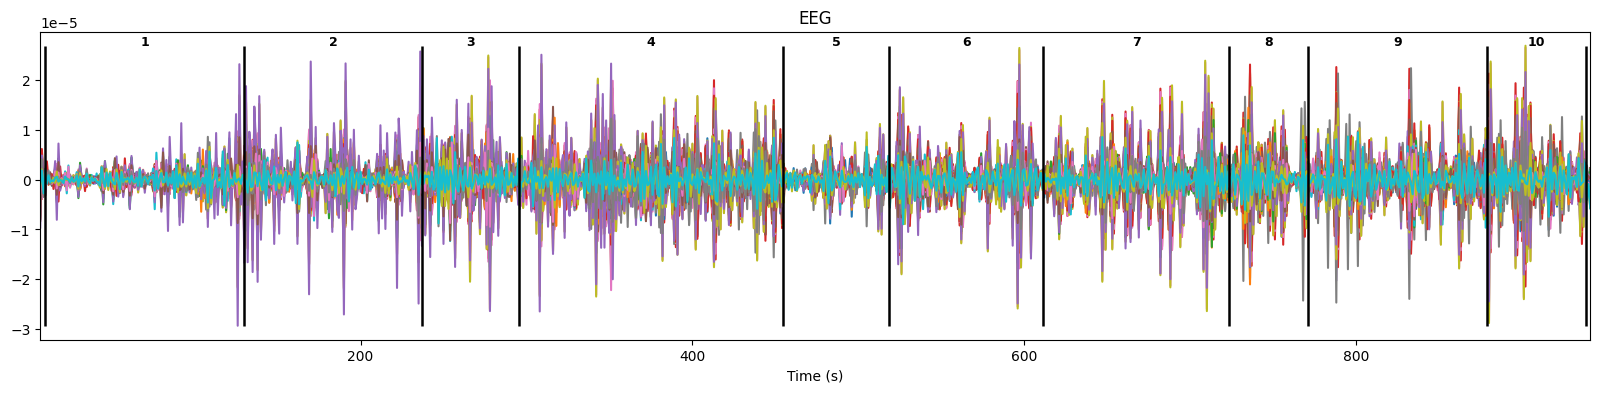

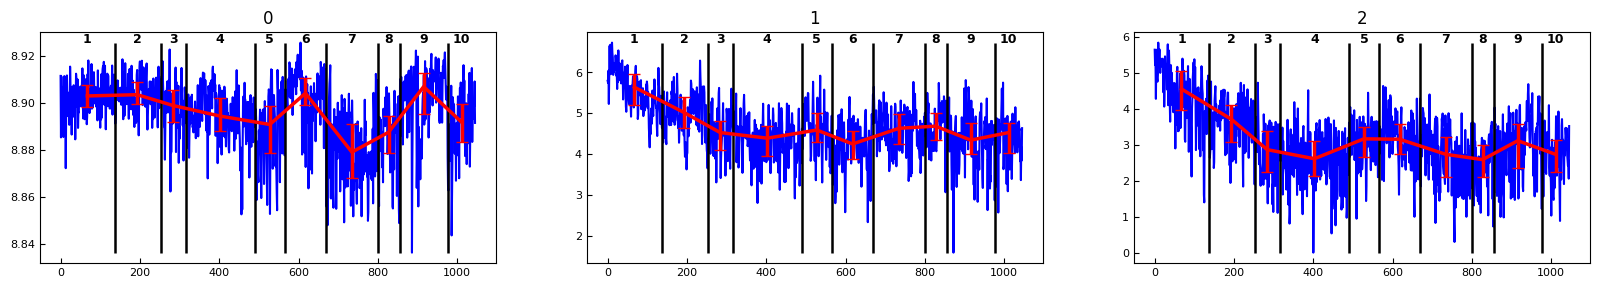

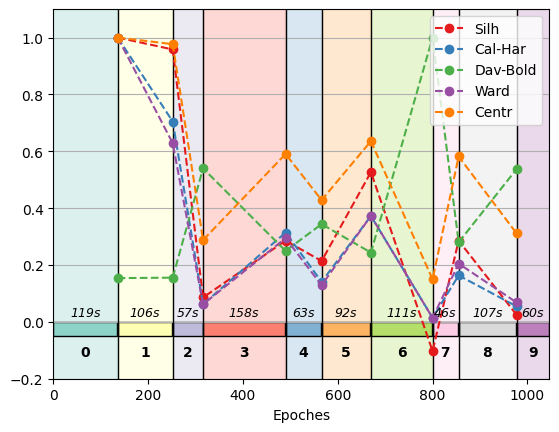

In [181]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")